# Implement smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

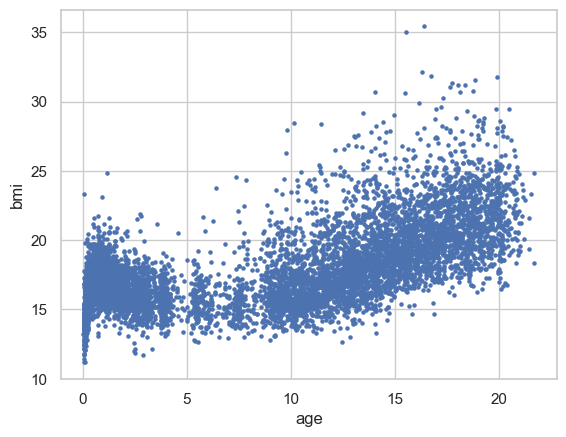

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=False)
X.smooth(data=df["age"].to_numpy())

# Set up hyperparameters for the beta_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=1.0, distribution=tau_dist, param_space="positive", name="tau")

# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(jnp.zeros(X.smooth_dim[0]), name="beta_smooth_loc")

# Define the penaly matrix from class Obs
pen = X.smooth_pen_mat[0]

# Set up parameters 
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=jnp.repeat(jnp.array([0.0]), X.smooth_dim[0]), distribution=beta_smooth_dist, name="beta_smooth")

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor 
lpred = tiger.Lpred(obs=X, beta_smooth=beta_smooth)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Implement the centering constraints

In [ ]:
# define a model with intercept 
# set up design matrix 
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the 
# smooth effects first 
X.center()

# fixed coefficents 
# set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# smooth coefficients
# set up hyperparameters for the beta_smooth_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.array([1.0]), distribution=tau_dist, param_space="positive", name="tau")

# smooth coefficients
# ----
# Easy way with the normal
# set up beta_fixed hyperparameters 
# beta_smooth_loc = tiger.Hyper(0.0, name="beta_smooth_loc")

# set up parameters 
# beta_smooth_dist = tiger.Dist(tfjd.Normal, loc=beta_smooth_loc, scale=tau)
# beta_smooth = tiger.Param(value=jnp.repeat(jnp.array([0.0]), X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# ----
# set up smooth coefficients with mvn degenerate 
# set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# define the penalty matrix 
pen = X.smooth_pen_mat_cent[0]

# set up parameters
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# set up the linear predictor
lpred = tiger.Lpred(Obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Test log-prob and setup the graph 

In [4]:
m.log_prob

Array(-35676.29, dtype=float32)

In [5]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

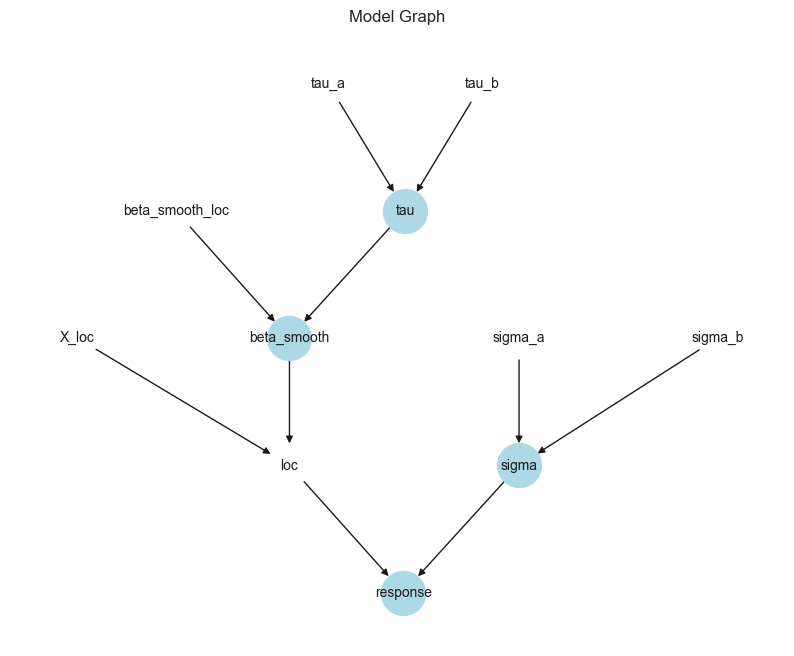

In [6]:
graph.visualize_graph()

## Inference with BBVI

In [7]:
q = bbvi.Bbvi(graph=graph)

In [17]:
import optax
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.,
    peak_value=0.2,
    warmup_steps=100,
    decay_steps=2_000,
    end_value=0.001,
)

Array(2.2910266, dtype=float32, weak_type=True)

In [8]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=27,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=2500)

(Array(-7816.9204, dtype=float32, weak_type=True),
 {'tau': {'loc': Array([-6.1359], dtype=float32, weak_type=True),
   'cov': Array([[0.00041079]], dtype=float32)},
  'sigma': {'loc': Array([0.82979286], dtype=float32, weak_type=True),
   'cov': Array([[7.084777e-05]], dtype=float32)},
  'beta_smooth': {'loc': Array([16.07451 , 16.322023, 16.570526, 16.818937, 17.067875, 17.315298,
          17.564833, 17.812973, 18.061953, 18.311136, 18.56036 , 18.809372,
          19.05839 , 19.308067, 19.557825, 19.806786, 20.0567  , 20.306574,
          20.555998, 20.805674], dtype=float32),
   'cov': Array([[ 4.05638239e-05,  3.51547606e-05,  3.07294285e-05,
            2.72788893e-05,  2.44514958e-05,  2.19458343e-05,
            1.97564277e-05,  1.76790563e-05,  1.56619590e-05,
            1.37043990e-05,  1.17809950e-05,  9.93370031e-06,
            8.13970928e-06,  6.40156804e-06,  4.69955057e-06,
            3.02922967e-06,  1.39856411e-06, -1.47071844e-07,
           -1.59565002e-06, -2.768

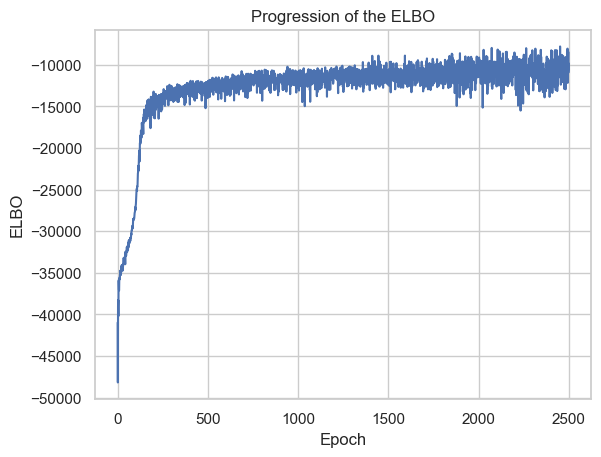

In [9]:
q.plot_elbo()

## Visualize the regression line 

In [22]:
b = q.trans_variational_params["beta_smooth"]["loc"]
b

Array([16.07451 , 16.322023, 16.570526, 16.818937, 17.067875, 17.315298,
       17.564833, 17.812973, 18.061953, 18.311136, 18.56036 , 18.809372,
       19.05839 , 19.308067, 19.557825, 19.806786, 20.0567  , 20.306574,
       20.555998, 20.805674], dtype=float32)

In [23]:
# plot the regression line 
b = q.trans_variational_params["beta_smooth"]["loc"]
x_new = jnp.linspace(df["age"].to_numpy().min(), df["age"].to_numpy().max(), num=100)
X_new = tiger.Obs(name="X_pred", intercept=False)
X_new.smooth(data = x_new)
y = X_new.design_matrix @ b

In [14]:
# for fixed and smooth terms
b_fixed = q.opt_variational_params["beta_fixed"]["loc"]
b_smooth = q.opt_variational_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y = X.design_matrix @ b

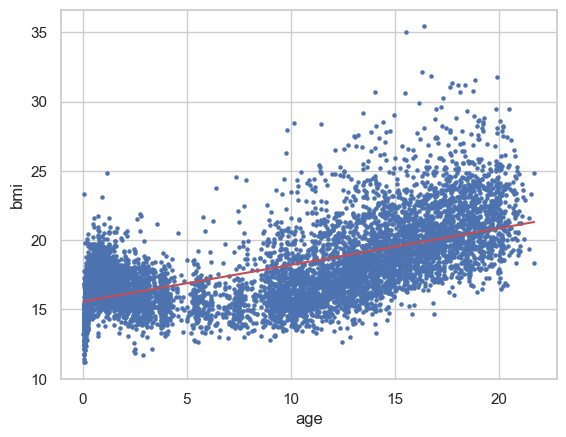

In [24]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(x_new, y, color = "r")
#ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [25]:
tau = q.trans_variational_params["tau"]["loc"]
s = q.trans_variational_params["tau"]["cov"]

In [26]:
m = jnp.exp(tau + s/2)

In [27]:
1 / (m ** 2)

Array([[213499.36]], dtype=float32)

In [28]:
tau

Array([-6.1359], dtype=float32, weak_type=True)